In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
import spacy
from scipy.io import savemat
import dill as pickle
import thop
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskTwo
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
onoffdict={'GPS': False, 'CAMERAS': False, 'RADAR': False}
lr=2e-3
num_epochs=200
#encoding_features=1024 #keep it in power of 2
reduction = 4
batch_size = 200
weight_path=f'models0/CRNettask2/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [3]:
reduction

4

In [4]:
weight_path

'models0/CRNettask2/cr4/gpsFalse_camFalse_radFalse/'

In [5]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Analysis

In [7]:
train_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=5)
test_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=5)

In [8]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

# Utils and Models

In [9]:
def CSI_ri_avg(y):
    ry=y[:,0,:,:]
    iy=y[:,1,:,:]
    y = torch.sqrt(ry**2+iy**2)
    return y

In [10]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [11]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum(x_real** 2 + x_imag** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [12]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [13]:
class CRBlock(nn.Module):
    def __init__(self):
        super(CRBlock, self).__init__()
        self.path1 = nn.Sequential(OrderedDict([
            ('conv3x3', ConvBN(2, 7, 3)),
            ('relu1', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ('conv1x9', ConvBN(7, 7, [1, 9])),
            ('relu2', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ('conv9x1', ConvBN(7, 7, [9, 1])),
        ]))
        self.path2 = nn.Sequential(OrderedDict([
            ('conv1x5', ConvBN(2, 7, [1, 5])),
            ('relu', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ('conv5x1', ConvBN(7, 7, [5, 1])),
        ]))
        self.conv1x1 = ConvBN(7 * 2, 2, 1)
        self.identity = nn.Identity()
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)

    def forward(self, x):
        identity = self.identity(x)

        out1 = self.path1(x)
        out2 = self.path2(x)
        out = torch.cat((out1, out2), dim=1)
        out = self.relu(out)
        out = self.conv1x1(out)

        out = self.relu(out + identity)
        return out


In [14]:
class task2Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Encoder, self).__init__()
        self.total_size =8192
        n1=int(math.log2(reduction))
        self.encoder1 = nn.Sequential(OrderedDict([
            ("conv3x3_bn", ConvBN(2, 2, 3)),
            ("relu1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv1x9_bn", ConvBN(2, 2, [1, 9])),
            ("relu2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv9x1_bn", ConvBN(2, 2, [9, 1])),
        ]))
        self.encoder2 = ConvBN(2, 2, 3)
        self.encoder_conv = nn.Sequential(OrderedDict([
            ("relu1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv1x1_bn", ConvBN(4, 2, 1)),
            ("relu2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ]))
        
        self.encoder_fc = nn.Linear(self.total_size, self.total_size // reduction)
        self.output_sig = nn.Sigmoid()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        
    def forward(self, x):
        n, c, h, w = x.detach().size()
        
        encode1 = self.encoder1(x.to(torch.float32))
        encode2 = self.encoder2(x)
        out = torch.cat((encode1, encode2), dim=1)
        out = self.encoder_conv(out)
        out =  self.encoder_fc(out.view(n, -1))
        
        return out
       

In [15]:
class task2Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        self.reduced_size = self.total_size//reduction
        self.decoder_fc = nn.Linear(self.total_size // reduction, self.total_size)
        
        decoder = OrderedDict([
            ("conv5x5_bn", ConvBN(2, 2, 5)),
            ("relu", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("CRBlock1", CRBlock()),
            ("CRBlock2", CRBlock())
        ])
        self.decoder_feature = nn.Sequential(decoder)
        self.sigmoid = nn.Sigmoid()
        
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        
    def forward(self, Hencoded):
        bs = Hencoded.size(0)
        #combining
        out = Hencoded.view(bs, self.reduced_size)
        # Generate final output
        out = self.decoder_fc(out)
        out = out.view(bs, -1, 64, 64)
        out = self.decoder_feature(out)
        
        return out

In [16]:
#complete task 2 model including encoder, decoder and channel
class task2model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        
        self.en=task2Encoder(reduction)
        
        self.de=task2Decoder(reduction)
        
    
   
    def forward(self, Hin, device, is_training): 
        
        #Encoder
        Hencoded=self.en(Hin)
        
        
        #Decoder   
        Hdecoded=self.de(Hencoded)
        

        return Hdecoded

In [17]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [18]:
model=task2model(reduction)
print(f'Number of parameters in Task2 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task2 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task2 Encoder: 16779436
Number of parameters in Task2 Decoder: 16788362


In [19]:
# Training

In [20]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [22]:
scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                            T_max=num_epochs * len(train_loader),
                                            T_warmup=30 * len(train_loader),
                                            eta_min=5e-5)

In [23]:
model=model.to(device)

In [24]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []

patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    
    epoch_time = time.time()
    model.train()
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_train=y_train.to(device)
        # Apply the model
        Xin = CSI_reshape(X_train[0])
        y_pred=model(Xin.to(device), device, is_training=True)
        y_train_reshaped=CSI_reshape(y_train)
        loss = criterion(y_pred, y_train_reshaped) 
        # Update parameters
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss1=loss1+loss
        
            
    train_loss=loss1/num_train_batches  
    train_losses.append(train_loss.item())
    
    
   
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1=0 
        nmse1=0
        for b, (X_test, y_test) in enumerate(test_loader):
            y_test=y_test.to(device)
            # Apply the model
            Xin = CSI_reshape(X_test[0])
            y_pred=model(Xin.to(device), device, is_training=True)
            y_test_reshaped=CSI_reshape(y_test)
            loss = criterion(y_pred, y_test_reshaped) 
            loss1=loss1+loss  
            
        val_loss=loss1/num_test_batches 
        val_losses.append(val_loss.item())
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss.item():10.8f} average reshaped VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
        # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path+"task2.pth")
        torch.save(model.en, weight_path+"task2Encoder.pth")
        torch.save(model.de, weight_path+"task2Decoder.pth")

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/200 average reshaped TL:2.49652672 average reshaped VL:2.33276367 epoch time:392 seconds, lr:6.67e-05
epoch:2/200 average reshaped TL:1.38079071 average reshaped VL:1.33898783 epoch time:418 seconds, lr:1.33e-04
epoch:3/200 average reshaped TL:1.11345458 average reshaped VL:1.16081452 epoch time:415 seconds, lr:2.00e-04
epoch:4/200 average reshaped TL:1.02100611 average reshaped VL:1.03747523 epoch time:460 seconds, lr:2.67e-04
epoch:5/200 average reshaped TL:0.93179536 average reshaped VL:0.96395475 epoch time:450 seconds, lr:3.33e-04
epoch:6/200 average reshaped TL:0.86161411 average reshaped VL:0.91083884 epoch time:451 seconds, lr:4.00e-04
epoch:7/200 average reshaped TL:0.82522881 average reshaped VL:0.87217468 epoch time:461 seconds, lr:4.67e-04
epoch:8/200 average reshaped TL:0.80530298 average reshaped VL:0.89239717 epoch time:461 seconds, lr:5.33e-04
epoch:9/200 average reshaped TL:0.76502740 average reshaped VL:0.83565825 epoch time:457 seconds, lr:6.00e-04
epoch:10/2

epoch:75/200 average reshaped TL:0.24443723 average reshaped VL:0.66148180 epoch time:437 seconds, lr:1.68e-03
epoch:76/200 average reshaped TL:0.23874469 average reshaped VL:0.66018230 epoch time:434 seconds, lr:1.67e-03
epoch:77/200 average reshaped TL:0.23424700 average reshaped VL:0.68416333 epoch time:430 seconds, lr:1.65e-03
epoch:78/200 average reshaped TL:0.23786473 average reshaped VL:0.65729994 epoch time:387 seconds, lr:1.64e-03
epoch:79/200 average reshaped TL:0.23467961 average reshaped VL:0.64816588 epoch time:390 seconds, lr:1.63e-03
epoch:80/200 average reshaped TL:0.22666462 average reshaped VL:0.64408875 epoch time:413 seconds, lr:1.61e-03
epoch:81/200 average reshaped TL:0.22364840 average reshaped VL:0.65664530 epoch time:399 seconds, lr:1.60e-03
epoch:82/200 average reshaped TL:0.22288495 average reshaped VL:0.66168481 epoch time:424 seconds, lr:1.58e-03
epoch:83/200 average reshaped TL:0.22098391 average reshaped VL:0.64578980 epoch time:401 seconds, lr:1.57e-03
e

epoch:149/200 average reshaped TL:0.13870747 average reshaped VL:0.64478612 epoch time:344 seconds, lr:4.52e-04
epoch:150/200 average reshaped TL:0.13651049 average reshaped VL:0.66813231 epoch time:342 seconds, lr:4.37e-04
epoch:151/200 average reshaped TL:0.13650015 average reshaped VL:0.65959895 epoch time:331 seconds, lr:4.23e-04
epoch:152/200 average reshaped TL:0.13525753 average reshaped VL:0.65399790 epoch time:334 seconds, lr:4.09e-04
epoch:153/200 average reshaped TL:0.13689408 average reshaped VL:0.68500024 epoch time:343 seconds, lr:3.95e-04
epoch:154/200 average reshaped TL:0.13380672 average reshaped VL:0.65766728 epoch time:332 seconds, lr:3.82e-04
epoch:155/200 average reshaped TL:0.13521300 average reshaped VL:0.66536480 epoch time:332 seconds, lr:3.68e-04
epoch:156/200 average reshaped TL:0.13503958 average reshaped VL:0.66854721 epoch time:335 seconds, lr:3.55e-04
epoch:157/200 average reshaped TL:0.13488415 average reshaped VL:0.65470725 epoch time:343 seconds, lr:3

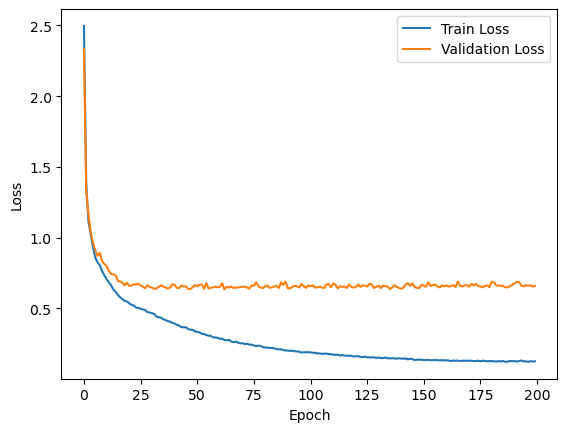

In [25]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
flops, params = thop.profile(model, inputs=(Xin.to(device), device, True, ), verbose=False)
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')

Model Flops: 4706304000.0
Model Params Num: 33567798.0



In [27]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

# Inference

In [28]:
#Create an instance of your model
#model = task2model()

model2=torch.load(weight_path+"task2.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    for b, (X_test, y_test) in enumerate(test_loader):

        y_test=y_test.to(device)
        # Apply the model
        Xin = CSI_reshape(X_test[0])
        y_pred=model2(Xin.to(device), device, is_training=False)
        y_test_reshaped = CSI_reshape(y_test)
        mse0 = criterion(CSI_ri_avg(y_pred), CSI_ri_avg(y_test_reshaped))
        mse1+=mse0 
        
    avg_mse=mse1/num_test_batches

In [29]:
print(f'Average MSE:{avg_mse}')


Average MSE:0.6370053887367249


In [30]:
h_list = torch.tensor([])
for b, (x,h) in enumerate(test_loader):
    h = CSI_ri_avg(CSI_reshape(h))
    h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [31]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 54.8689%


In [32]:
target_loss

tensor(1.4115)